##  Credit Risk Modelling 

This notebook covers training and evaluating different models to predict loan defaults

In [28]:
import pandas as pd
import numpy as np
from credit_risk_model.data_cleaning import clean_all
from credit_risk_model.feat_eng import engineer_features
from credit_risk_model.model import(
     train_logistic_regression,
     train_xgboost, train_lightgbm,
    compare_models,hyperparameter_tuning_xgboost, 
    hyperparameter_tuning_lightgbm,
    compare_tuned_and_baseline_models
)
import matplotlib.pyplot as plt
import seaborn as sns
from credit_risk_model.config import DATA_PROCESSED, MODELS_DIR, RESULTS_DIR

# Import necessary libraries for modelling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, 
    classification_report,
    confusion_matrix
)
import joblib

In [2]:
df = pd.read_csv(DATA_PROCESSED/"agg_main.csv")

In [3]:
df.head()

,target,credit_income_ratio,total_income,total_credit_requested,monthly_loan_payment,value_of_goods_financed,age_years,employment_years,NAME_CONTRACT_TYPE,CODE_GENDER,...,avg_amt_credit,approval_rate,n_active_contracts,avg_months_active,n_completed_contracts,avg_payment_ratio,installments_n_late_payments,avg_balance,max_balance,avg_utilization
0,0,2.857143,157500.0,450000.0,35685.0,450000.0,59.309589,12.909589,Cash loans,F,...,443773.607143,0.428571,34.0,-34.794118,5.0,1.056709,2.0,29452.900500,158449.500,NaN
1,0,1.200000,112500.0,135000.0,7879.5,135000.0,48.030137,0.441096,Cash loans,F,...,170367.750000,0.750000,59.0,-26.881356,4.0,1.000000,0.0,0.000000,0.000,0.000000
2,0,6.040000,112500.0,679500.0,19867.5,679500.0,37.117808,5.468493,Cash loans,F,...,145647.750000,0.833333,35.0,-28.428571,3.0,0.897436,7.0,0.000000,0.000,0.000000
3,0,2.900000,225000.0,652500.0,47610.0,652500.0,38.049315,6.347945,Cash loans,M,...,167734.500000,1.000000,24.0,-29.000000,2.0,0.941860,3.0,279583.392414,463463.865,0.759396
4,0,0.733333,135000.0,99000.0,10395.0,99000.0,27.446575,1.038356,Cash loans,F,...,146957.785714,1.000000,49.0,-47.367347,4.0,0.979031,16.0,193191.533710,463813.695,0.674371


## split data

splitting is done so early here to avoid leakage of information from the validation set into the training process, since cleaning uses data level statistics 


In [4]:
# split
X = df.drop('target', axis=1)
y = df['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)


In [5]:
#clean data
X_train = clean_all(X_train)
X_val = clean_all(X_val)

In [6]:
# feature engineering
X_train = engineer_features(X_train)
X_val = engineer_features(X_val)

# Replace infinity with 0
X_train = X_train.replace([np.inf, -np.inf], 0)
X_val = X_val.replace([np.inf, -np.inf], 0)

#save processed data
X_train.to_csv(DATA_PROCESSED/"feature_engineered.csv", index=False)
X_val.to_csv(DATA_PROCESSED/"feature_engineered_val.csv", index=False)
y_val.to_csv(DATA_PROCESSED/"target_val.csv", index=False)
y_train.to_csv(DATA_PROCESSED/"target_train.csv", index=False)

## Evaluate models 

### Baseline model (Logistic Regression)
scaling is done here on only the continuous cols ommiting encoded cols and binary cols

NOTE: tree based models don't require scaling, it is only done here for logistic regression

In [27]:
log_reg_pipe, y_proba, y_pred = train_logistic_regression(
    X_train, y_train, X_val, y_val
)

print("="*50)
print("BASELINE MODEL PERFORMANCE (Logistic Regression)")
print("="*50)

print(f"\nROC-AUC Score: {roc_auc_score(y_val, y_proba):.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

BASELINE MODEL PERFORMANCE (Logistic Regression)

ROC-AUC Score: 0.6980

Confusion Matrix:
[[36284 20254]
 [ 1725  3240]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.64      0.77     56538
           1       0.14      0.65      0.23      4965

    accuracy                           0.64     61503
   macro avg       0.55      0.65      0.50     61503
weighted avg       0.89      0.64      0.72     61503



### XGBoost

In [8]:
xgb_model, y_proba_xgb, y_pred_xgb = train_xgboost(
    X_train, y_train, X_val, y_val
)

print("="*50)
print("XGBoost Performance")
print("="*50)
print(f"ROC-AUC: {roc_auc_score(y_val, y_proba_xgb):.4f}")
print("\n", classification_report(y_val, y_pred_xgb))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_xgb))

XGBoost Performance
ROC-AUC: 0.7223

               precision    recall  f1-score   support

           0       0.94      0.90      0.92     56538
           1       0.22      0.32      0.26      4965

    accuracy                           0.86     61503
   macro avg       0.58      0.61      0.59     61503
weighted avg       0.88      0.86      0.87     61503


Confusion Matrix:
[[50994  5544]
 [ 3369  1596]]


### Lightboost 

In [9]:
lgbm_model, y_proba_lgbm, y_pred_lgbm = train_lightgbm(
    X_train, y_train, X_val, y_val
)

print("="*50)
print("LightGBM Performance")
print("="*50)
print(f"ROC-AUC: {roc_auc_score(y_val, y_proba_lgbm):.4f}")
print("\n", classification_report(y_val, y_pred_lgbm))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_lgbm))

LightGBM Performance
ROC-AUC: 0.7208

               precision    recall  f1-score   support

           0       0.94      0.90      0.92     56538
           1       0.22      0.32      0.26      4965

    accuracy                           0.86     61503
   macro avg       0.58      0.61      0.59     61503
weighted avg       0.88      0.86      0.87     61503


Confusion Matrix:
[[51058  5480]
 [ 3395  1570]]


### Compare results

In [10]:
results_df = compare_models(X_val, y_val, log_reg_pipe, xgb_model, lgbm_model)
results_df

,AUC-ROC,AUC-PR,Precision,Recall,F1-score,KS,Gini
XGBoost,0.722349,0.198046,0.223529,0.321450,0.263693,0.331434,0.444698
LightGBM,0.720771,0.196545,0.222695,0.316213,0.261340,0.328184,0.441542
LogisticRegression,0.698033,0.168851,0.081359,0.999194,0.150466,0.297453,0.396066


## Hyperparameter Tuning 

### Hyperparameter tuning for xgboost

In [14]:
xgb_tuned = hyperparameter_tuning_xgboost(X_train, y_train, X_val, y_val) 

[I 2025-12-05 08:54:10,825] A new study created in memory with name: no-name-9247b015-902d-4091-b5ac-44b6a4c48712
[I 2025-12-05 08:54:37,391] Trial 0 finished with value: 0.7209983966794054 and parameters: {'n_estimators': 757, 'max_depth': 4, 'learning_rate': 0.1771473182172435, 'subsample': 0.8711408689564074, 'colsample_bytree': 0.8957463867451604, 'gamma': 0.32682067521882185, 'min_child_weight': 1, 'reg_alpha': 1.171416305094744, 'reg_lambda': 1.85726070188778}. Best is trial 0 with value: 0.7209983966794054.
[I 2025-12-05 08:54:58,638] Trial 1 finished with value: 0.7197204692638344 and parameters: {'n_estimators': 705, 'max_depth': 5, 'learning_rate': 0.12212005925469249, 'subsample': 0.7712317218259733, 'colsample_bytree': 0.8299038508576664, 'gamma': 9.076602025313312, 'min_child_weight': 4, 'reg_alpha': 4.086582160562948, 'reg_lambda': 0.42586740410354096}. Best is trial 0 with value: 0.7209983966794054.
[I 2025-12-05 08:55:20,233] Trial 2 finished with value: 0.7196138080290

### Hyperparameter tuning for LightGBM

In [11]:
lgbm_tuned = hyperparameter_tuning_lightgbm(X_train, y_train, X_val, y_val)

[I 2025-12-05 08:29:18,028] A new study created in memory with name: no-name-f8646bff-d72b-4b13-9ede-5b23e2668fb8
[I 2025-12-05 08:30:28,907] Trial 0 finished with value: 0.7208106040098083 and parameters: {'num_leaves': 125, 'max_depth': 7, 'learning_rate': 0.020162997295661057, 'n_estimators': 462, 'subsample': 0.6404261005432353, 'colsample_bytree': 0.9581517636211921, 'min_child_samples': 146, 'reg_lambda': 4.083914478302951, 'reg_alpha': 3.897828841746578}. Best is trial 0 with value: 0.7208106040098083.
[I 2025-12-05 08:31:21,713] Trial 1 finished with value: 0.7177759492078637 and parameters: {'num_leaves': 122, 'max_depth': 8, 'learning_rate': 0.04902356227878083, 'n_estimators': 474, 'subsample': 0.9390772137564901, 'colsample_bytree': 0.9945549069737383, 'min_child_samples': 68, 'reg_lambda': 1.899894905192293, 'reg_alpha': 2.887810338015242}. Best is trial 0 with value: 0.7208106040098083.
[I 2025-12-05 08:32:00,359] Trial 2 finished with value: 0.7156791338228543 and parame

## Compare all models(baseline and tuned)

In [ ]:
results_df = compare_tuned_and_baseline_models(X_val, y_val, xgb_model, lgbm_model, xgb_tuned, lgbm_tuned)
print(results_df.to_string(index=False))

            Model  AUC-ROC   AUC-PR  Precision   Recall  F1-score       KS     Gini
 XGBoost Baseline 0.722349 0.198046   0.223529 0.321450  0.263693 0.331434 0.444698
    XGBoost Tuned 0.724171 0.200620   0.222761 0.323666  0.263897 0.334478 0.448342
LightGBM Baseline 0.720771 0.196545   0.222695 0.316213  0.261340 0.328184 0.441542
   LightGBM Tuned 0.725691 0.200760   0.226342 0.318429  0.264603 0.338124 0.451382


LightGBM tuned performed best in all evaluation metrics except recall. Hence, it is chosen as the final model.

## Confusion Matrix

0.7256908016877276


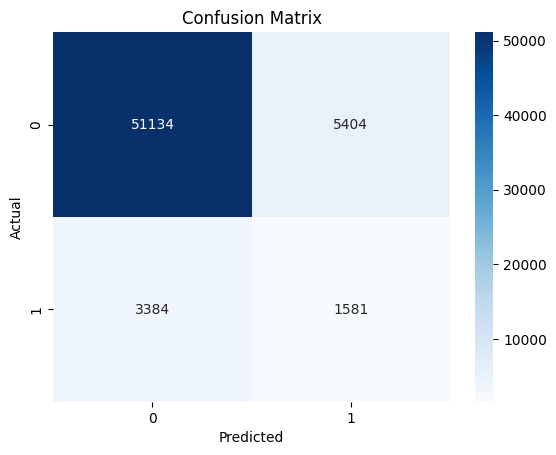

In [38]:
# Get predictions
y_proba_lgbm_tuned = lgbm_tuned.predict_proba(X_val)[:, 1]
y_pred_lgbm_tuned = (y_proba_lgbm_tuned >= 0.15).astype(int) 


print(roc_auc_score(y_val, y_proba_lgbm_tuned))

cm = confusion_matrix(y_val, y_pred_lgbm_tuned)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.savefig(f"{RESULTS_DIR}\\explainability\\confusion_matrix_lgbm_tuned.png", bbox_inches='tight', )


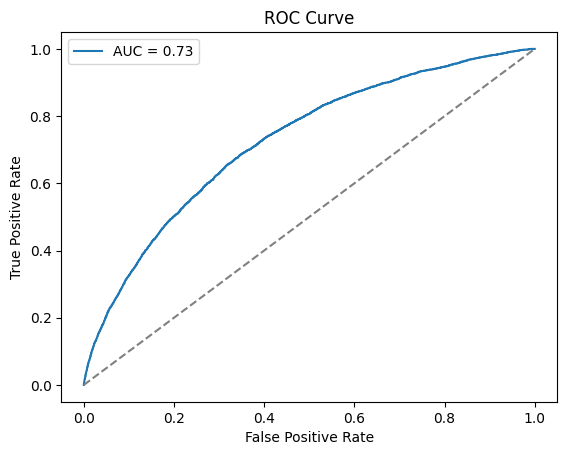

In [42]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_val, y_proba_lgbm_tuned)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.savefig(f"{RESULTS_DIR}\\explainability\\roc_curve.png", dpi=300, bbox_inches="tight")

### Feature Importance

In [ ]:
# Get feature importances from tuned LightGBM model
importance = lgbm_tuned.feature_importances_

feat_imp_df_lgbm = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importance
}).sort_values("importance", ascending=False)

feat_imp_df_lgbm.head(30)


,feature,importance
4,value_of_goods_financed,187
3,monthly_loan_payment,176
5,age_years,170
2,total_credit_requested,167
21,avg_amt_credit,156
20,avg_amt_applied,151
24,avg_months_active,151
12,avg_debt_ratio,142
51,income_per_loan,128
6,employment_years,125


### Save best model (XGBoost)

In [44]:
all_models = {
    "log_reg": log_reg_pipe,
    "XGBoost": xgb_tuned,
    "LightGBM": lgbm_tuned,
}

for name, model in all_models.items():
    joblib.dump(model, f"{MODELS_DIR}/{name}.joblib")
